In [1]:
import sys
import numpy as np
import cv2


import os
import scipy.misc
from scipy.optimize import least_squares
import math
from copy import deepcopy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [2]:
image_data_dir = '../data/statue/'

image_paths = [os.path.join(image_data_dir, 'images', x) for x in sorted(os.listdir('../data/statue/images')) if '.jpg' in x]

In [3]:
unit_test_image_matches = np.load('../data/unit_test_image_matches.npy')

In [4]:
unit_test_image_matches.shape

(4, 2)

In [5]:
len(image_paths)

5

In [6]:
matches_subset = np.load(os.path.join(image_data_dir,'matches_subset.npy'), allow_pickle=True,encoding='latin1')[0,:]
fundamental_matrices = np.load(os.path.join(image_data_dir,'fundamental_matrices.npy'),allow_pickle=True,encoding='latin1')[0,:]

In [7]:
len(matches_subset)

4

In [8]:
matches_subset[0].shape

(4, 50)

In [9]:
len(fundamental_matrices)

4

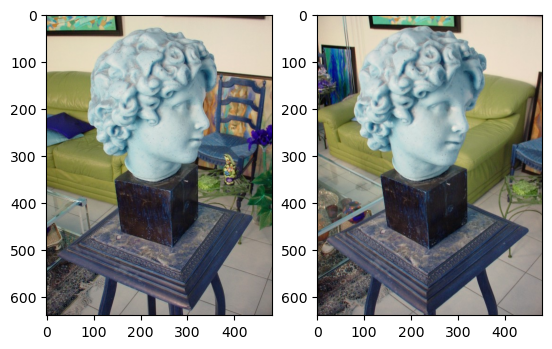

In [10]:
im0 = cv2.imread(image_paths[0])
im1 = cv2.imread(image_paths[1])
plt.subplot(121)
plt.imshow(im0)
plt.subplot(122)
plt.imshow(im1)
im_height, im_width, _ = im0.shape

* Nous considérons des paires de caméras séquentielles pour déterminer les matrices de caméras

$$M_1=K[I\mid 0]$$ et $$M_2=K[R \mid t]$$  où

$$K=\begin{bmatrix}
f & 0 &0 \\
 0&f  &0 \\
0 & 0 & 1
\end{bmatrix}$$

In [11]:

focal_length = 719.5459

K = np.eye(3)
K[0,0] = K[1,1] = focal_length


In [12]:

example_RT = np.array([[0.9736, -0.0988, -0.2056, 0.9994],
        [0.1019, 0.9948, 0.0045, -0.0089],
        [0.2041, -0.0254, 0.9786, 0.0331]])

In [13]:
camera_matrices = np.zeros((2, 3, 4))
camera_matrices[0, :, :] = K.dot(np.hstack((np.eye(3), np.zeros((3,1)))))
camera_matrices[1, :, :] = K.dot(example_RT)

image_points = matches_subset[0][:,0].reshape(2,2)

* En utilisant les contraintes des deux images, nous pouvons
formuler une équation linéaire de la forme $AP = 0$ où

$$A=\begin{bmatrix}
  xM_3-M_1\\
  yM_3-M_2  \\
  x'M_3-M'_1  \\
   y'M_3-M'_2
\end{bmatrix}$$
Cette équation peut être résolue à l'aide de la méthode SVD pour trouver la meilleure estimation linéaire du point P

In [14]:
N = image_points.shape[0]
A = np.zeros((2*N, 4))
A_set = []

for i in range(N):
        pi = image_points[i]
        Mi = camera_matrices[i]
        Aix = pi[0]*Mi[2] - Mi[0]
        Aiy = pi[1]*Mi[2] - Mi[1]
        A_set.append(Aix)
        A_set.append(Aiy)

for i in range(A.shape[0]):
        A[i] = A_set[i]

U, s, VT = np.linalg.svd(A)
P_homo = VT[-1]
P_homo /= P_homo[-1]
estimated_3d_point = P_homo[:3]


In [15]:

expected_3d_point = np.array([0.6774, -1.1029, 4.6621])
print("Difference: ", np.fabs(estimated_3d_point - expected_3d_point).sum())

Difference:  0.0029243053036863698
